In [39]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import norm
import time
import xarray as xr

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] #added from snow class

from mpl_toolkits.axes_grid1 import make_axes_locatable

<xarray.Dataset>
Dimensions:  (time: 6, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2013-04-03 2014-04-07 ... 2018-04-23
    mask     (y, x) uint8 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 600), meta=np.ndarray>


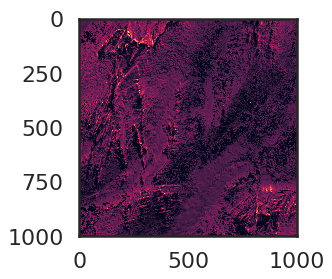

In [6]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()
# #~~~~ ds peak
dpeak = ds.isel(time=[0,7,18,30,42,49]) 
dpeak.close()
ds = dpeak
ds.close()
#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
#grab 2015, 2016, 2017 nearest peak SWE
# ds=ds.isel(time=slice(2,5))
# ds.close()
#northern slice of data
d = ds.isel(x=slice(8400,9400), y=slice(3000,4000))
d.close()
#~~~convert to ints again
d=d.astype(np.int16, copy=False)
print(d)
plt.imshow(d.snow.isel(time=1))

#dataset is d here! 1km by 1km area in northern Tuolumne (2 valleys west of slide canyon)

In [35]:
# compute stats from xarray dataset
x_gt0 = d.snow.where(d.snow>0) #snow depths greater than zero
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

mu=mu_gt0
sigma=sig_gt0

In [36]:
x_gt0.shape
mu.shape
sigma.shape

(6,)

In [37]:
n_bins=10
hist, bins = np.histogram(x_gt0.values[~np.isnan(x_gt0.values)], bins=n_bins, density=True)

In [42]:
y = norm.pdf(bins, mu.values, sigma.values).cumsum()
y /= y[-1]

ValueError: operands could not be broadcast together with shapes (11,) (6,) 